## Student Name : Fergus Mc Hale
## Student ID : 18203485
## Classification

In [233]:
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score


from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from pprint import pprint

In [234]:
TEST_SIZE = 0.3
CSV_SPLIT = ';'

## Training Data

# https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

In [235]:
data = pd.read_csv('./data/Absenteeism_at_work.csv',sep=CSV_SPLIT, delimiter=None)

In [236]:
dataset = data.values

In [237]:
del data['ID']

In [238]:
X = dataset[:,1:19]
y = dataset[:,20]

In [239]:
print("Covariance matrix:\n", np.cov(X,rowvar=False))
# Create correlation matrix
corr_mat = np.corrcoef(X,rowvar=False)
print("\nCorrelation matrix:\n", corr_mat)

Covariance matrix:
 [[ 7.11223348e+01 -2.43016494e+00  1.39461654e+00 -1.10573090e+00
  -6.74069780e+01  2.02490217e+01  1.79073255e+00 -4.29499323e+00
  -4.06709115e+01  2.83483890e+00 -1.04011996e+00 -2.68880518e-01
  -5.12891782e-01  2.73598362e-01 -2.53958966e-01 -6.21585049e-01
  -2.92579454e-02 -4.03434151e+00]
 [-2.43016494e+00  1.18080679e+01 -3.18911604e-02  1.55791245e+00
   3.16398713e+01 -1.98186007e-01 -9.47189409e-01 -3.38294993e-02
  -2.28151183e+01 -5.97981202e+00  8.39337308e-02 -1.52982482e-01
   2.98321325e-01  9.57831986e-02 -3.45243755e-02  2.16472223e-01
   1.03053798e+00 -1.42972607e+00]
 [ 1.39461654e+00 -3.18911604e-02  2.02115898e+00  7.34904729e-02
   3.23514611e+00  2.48952383e+00  1.32483634e-01  4.10690122e-02
   8.68798124e-01  1.66486852e-01 -4.86413342e-03  5.60070219e-02
   1.53169001e-01  2.94408075e-02  4.86779066e-03 -5.41345134e-02
  -2.36236331e+00 -7.04686757e-01]
 [-1.10573090e+00  1.55791245e+00  7.34904729e-02  1.23616831e+00
   2.75388216e+00

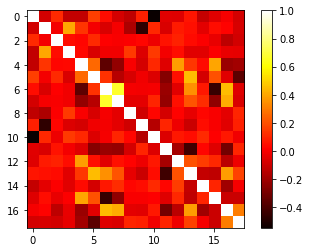

In [240]:
plt.imshow(corr_mat, cmap='hot')
plt.colorbar() 
plt.show()

In [241]:
data.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average per day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [242]:
data.isnull().sum().sort_values(ascending=False).head()

Absenteeism time in hours    0
Body mass index              0
Month of absence             0
Day of the week              0
Seasons                      0
dtype: int64

In [243]:
data['Age'].value_counts()

28    117
38    113
37     78
40     58
33     51
36     50
30     46
50     37
41     34
34     29
47     24
43     24
31     22
32     13
58      8
39      8
29      7
27      7
48      6
49      5
46      2
53      1
Name: Age, dtype: int64

In [244]:
data.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average per day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


## Preprocessing

In [245]:
data_scaled = preprocessing.scale(data)
print("\nAFTER:")
print("Mean =", data_scaled.mean(axis=0))
print("Std deviation =", data_scaled.std(axis=0))


AFTER:
Mean = [-1.63232791e-16 -1.34427004e-16  6.72135020e-17  5.76115732e-17
 -9.12183242e-17 -3.00060277e-17 -8.16163953e-17 -4.27285834e-16
 -4.22484870e-16 -2.49650150e-16  1.92038577e-17  1.34427004e-16
 -5.76115732e-17  7.68154309e-17 -5.04101265e-17 -9.60192886e-18
 -1.44028933e-17 -9.04981795e-16  1.12822664e-16  3.00060277e-17]
Std deviation = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\fergu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


## Normalization

In [246]:
# Normalize data use l2 to find outliners
data_normalized_l1 = preprocessing.normalize(data, norm='l1')
data_normalized_l2 = preprocessing.normalize(data, norm='l2')
print("\nL1 normalized data:\n", data_normalized_l1[data_normalized_l1 != 0.])
print("\nL2 normalized data:\n", data_normalized_l2[data_normalized_l2 != 0.])


L1 normalized data:
 [0.0248672  0.00669502 0.00286929 ... 0.08137651 0.18494661 0.02642094]

L2 normalized data:
 [0.05930386 0.01596642 0.00684275 ... 0.19440308 0.44182517 0.06311788]


In [247]:
variable_names = list(data)

## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html

In [248]:
# Find the Main Outliners to be used 
factor = FactorAnalysis().fit(data_normalized_l2)
pd.DataFrame(factor.components_ ,columns = variable_names)
transformed_outliner_factors = factor.transform(data_normalized_l2) 
score = factor.score(data_normalized_l2)
print("Score")
print(score)
score_of_each_sample = factor.score_samples(data_normalized_l2)

Score
67.57949188669066


In [249]:
print('Outiners')
outliners = transformed_outliner_factors[transformed_outliner_factors != 0.]
print(outliners)

Outiners
[ 0.4242015  -0.99418546 -0.49961436 ...  0.42383909 -0.47450632
 -0.27414211]


In [250]:
def plot_histogram(x):
    plt.hist(x, color='blue', alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

In [251]:
def find_outliers_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw="scott", fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]

    return outlier_ind, outlier_value

In [252]:
# Age
tukey_indices, tukey_values = find_outliers_kde(data['Age'])
print(np.sort(tukey_values))

[53 58 58 58 58 58 58 58 58]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


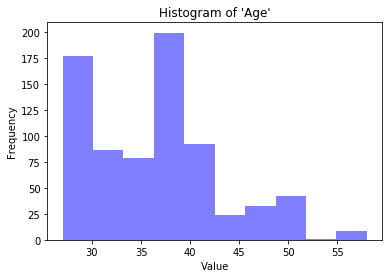

In [253]:
plot_histogram(data['Age'])

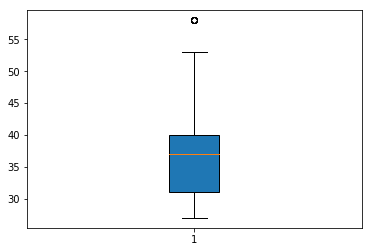

In [254]:
plt.boxplot(data['Age'],patch_artist=True, meanline=True)
plt.show()

In [255]:
# Hit Target
tukey_indices, tukey_values = find_outliers_kde(data['Hit target'])
print(np.sort(tukey_values))

[81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


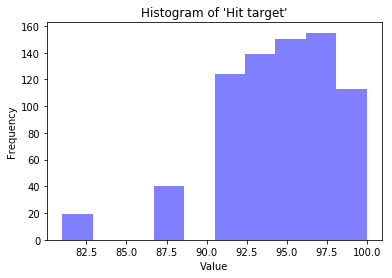

In [256]:
plot_histogram(data['Hit target'])

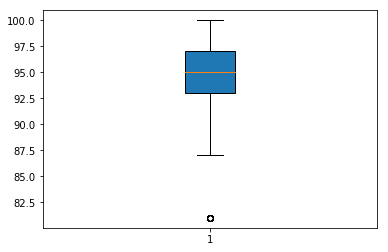

In [257]:
plt.boxplot(data['Hit target'],patch_artist=True, meanline=True)
plt.show()

In [258]:
#Service Time
tukey_indices, tukey_values = find_outliers_kde(data['Service time'])
print(np.sort(tukey_values))

[ 1  1  1  1  1  1  1 24 24 29 29 29 29 29]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


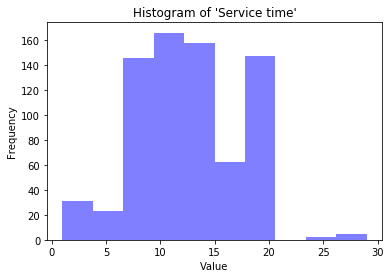

In [259]:
plot_histogram(data['Service time'])

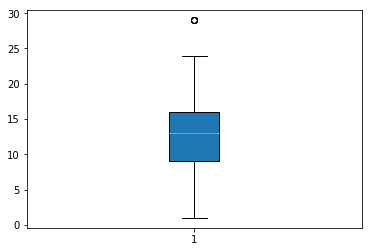

In [260]:
plt.boxplot(data['Service time'],patch_artist=True, meanline=True)
plt.show()

In [261]:
# Absenteeism time in hours
tukey_indices, tukey_values = find_outliers_kde(data['Absenteeism time in hours'])
print(np.sort(tukey_values))

[ 32  32  32  32  32  32  40  40  40  40  40  40  40  48  56  56  64  64
  64  80  80  80 104 112 112 120 120 120]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


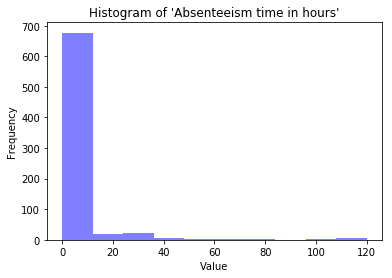

In [262]:
plot_histogram(data['Absenteeism time in hours'])

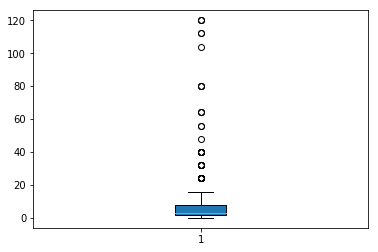

In [263]:
plt.boxplot(data['Absenteeism time in hours'],patch_artist=True, meanline=True)
plt.show()

In [264]:
# Son
tukey_indices, tukey_values = find_outliers_kde(data['Son'])
print(np.sort(tukey_values))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


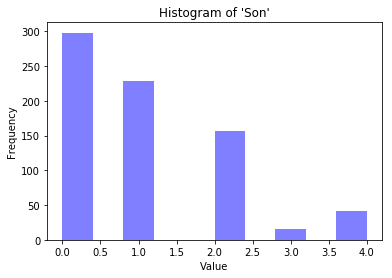

In [265]:
plot_histogram(data['Son'])

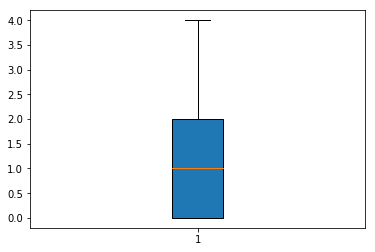

In [266]:
plt.boxplot(data['Son'],patch_artist=True, meanline=True)
plt.show()

In [267]:
# Weight
tukey_indices, tukey_values = find_outliers_kde(data['Weight'])
print(np.sort(tukey_values))

[108 108 108 108 108]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


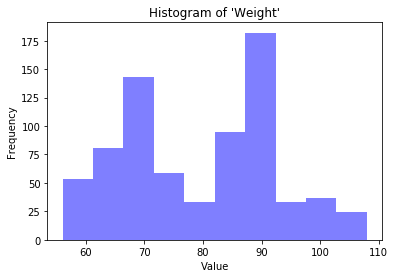

In [268]:
plot_histogram(data['Weight'])

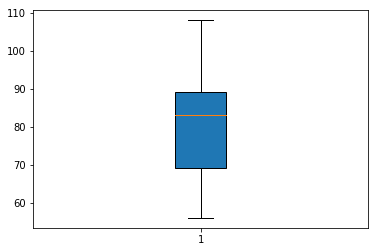

In [269]:
plt.boxplot(data['Weight'],patch_artist=True, meanline=True)
plt.show()

In [270]:
# Height
tukey_indices, tukey_values = find_outliers_kde(data['Height'])
print(np.sort(tukey_values))

[163 163 163 163 163 163 185 185 185 185 185 185 185]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [271]:
# Body Mass Index
tukey_indices, tukey_values = find_outliers_kde(data['Body mass index'])
print(np.sort(tukey_values))

[34 35 35 36 36 36 36 36 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38]


C:\Users\fergu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


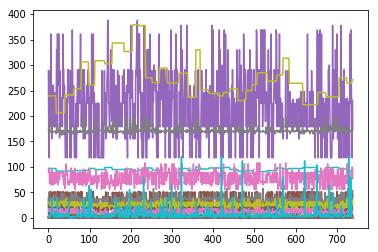

In [272]:
plt.plot(data)
plt.show()

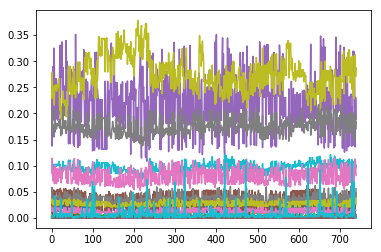

In [273]:
plt.plot(data_normalized_l1)
plt.show()

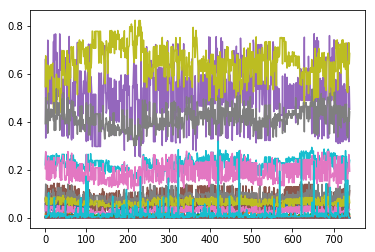

In [274]:
plt.plot(data_normalized_l2)
plt.show()

In [275]:
pprint(outliners.tolist())

[0.4242015007156788,
 -0.9941854562057604,
 -0.4996143581865563,
 -0.020580586745880165,
 0.1186252984356262,
 0.3589405134567208,
 -0.15192498920948366,
 -1.7896157834161917,
 -0.7097230271677479,
 2.245296571107617,
 0.09430765283735242,
 0.550400989738393,
 -0.188187457627043,
 -1.0838520286804436,
 -1.1540677976152007,
 -0.9056619566682999,
 -0.6997756870030264,
 0.0646006877631359,
 -0.06254013404611622,
 -0.0654324272167995,
 -0.24846318103834583,
 0.5530649309277741,
 -0.2916638567411981,
 0.4774109237898416,
 -0.0344413407652574,
 1.5961715502693388,
 -0.0704905091946624,
 0.038826500244104535,
 0.39236078577528277,
 -0.969469077492726,
 -0.5476463225264084,
 -0.17484500493628552,
 0.22266094217370092,
 0.10252102523395691,
 -0.12959932221553458,
 -1.2112073872777611,
 -0.8756845814017334,
 -0.8428438594690341,
 -0.11804292889094464,
 0.05694574031273873,
 -0.32910596641782164,
 -0.17205145189902915,
 1.6028674807936247,
 -0.8737581001380669,
 -0.9003570239408087,
 -0.405247924

 -0.46228370352103454,
 -0.4902152557137076,
 -0.6606101767384975,
 2.2429193730962473,
 0.005834856578177444,
 1.2957967155590135,
 0.44349061938076834,
 0.5579608828659472,
 -0.7186332674643882,
 -0.6304044788148927,
 1.7588909933470593,
 0.24356585023437347,
 1.488906938009903,
 0.7148774753729962,
 -0.22909401194893583,
 -0.45229054188547385,
 -0.5516776197055613,
 0.04229700346739979,
 -0.07323277800408502,
 0.3169332373888786,
 1.2896473267058763,
 -0.6892518800217855,
 -0.5281798099257381,
 0.017749918076553014,
 -0.5630985612509427,
 0.32922861013422594,
 0.9103232707590262,
 1.417601830017692,
 -0.22184409301051253,
 -0.07344125034760343,
 0.4346456148565855,
 1.9193536837580991,
 -0.18417751928833873,
 -0.36261610247926984,
 0.5241969595131032,
 -0.576317669497244,
 -0.30662389462269574,
 -0.07351667434518269,
 0.7420751254222147,
 0.27127325961101195,
 0.3387223060208765,
 1.192761690200572,
 -0.5031079524731296,
 -0.22973239929544606,
 0.25834744658317005,
 1.97182269805776

 -0.11717475123170398,
 -0.013844835197710252,
 -1.1927719702884736,
 -0.7292643391868163,
 -0.6271788921291233,
 -0.07933369943649475,
 -0.2774818192945031,
 -0.1981801725692897,
 -0.015954577645148217,
 1.5773079284496354,
 -0.7490573262601962,
 -0.73010148407,
 -0.4737054304499286,
 -0.3220736221934945,
 0.07621203078387588,
 -0.3736530816372662,
 0.43673288225103934,
 -0.7977787353666079,
 -0.6731910765302019,
 -0.4391401146281711,
 0.5442187305638638,
 -0.524201684685893,
 0.613054623529144,
 -0.41232164109736014,
 0.8025273561653596,
 0.612990550850108,
 -0.2904675591447537,
 1.5810277003993372,
 -0.06318401655209689,
 0.062270562942058544,
 -0.3894394306052602,
 0.800641071275087,
 0.7196207991115717,
 -0.26894951090191355,
 1.5949703272962406,
 -0.047103968752541595,
 0.050644785810587276,
 -0.23528662799835762,
 0.15758011698555835,
 0.31852747882475824,
 -0.2893763538913362,
 0.6734431839528043,
 0.20420994660184844,
 0.20679045146650507,
 0.31128701000205494,
 0.410372830995

 -1.3819112793870327,
 -0.9042823512360987,
 -0.9910387387447829,
 -0.108496079554464,
 0.0739272412738494,
 -0.20355197843920964,
 -0.22147250984118524,
 -0.3700192331594192,
 1.496112538752838,
 -1.1378187406869644,
 -0.8619292138867947,
 0.46534716093505246,
 -0.25884996058799997,
 -0.17651511221472477,
 -1.4112244888681436,
 -0.8888805014534249,
 -1.0645166479616126,
 -0.2023047911118653,
 0.13529933709028766,
 -0.338995649868179,
 -0.18221955947356125,
 -1.3507374660711025,
 -0.8873268927101216,
 -0.6949728842241037,
 -0.09468216414232546,
 -0.18688100653601095,
 -0.005096414703862831,
 -0.1848051668392256,
 -2.0044702251653734,
 -0.2035591856561403,
 0.3383251539459244,
 -0.1386640524802916,
 2.072021910523009,
 -0.25988866122056126,
 0.41898512046964725,
 -1.1187353467366743,
 -0.14325660034145044,
 0.3508867964754136,
 -0.07960503979934645,
 0.5018269438121788,
 0.5376788646886764,
 0.348794367483809,
 -1.3801523393509847,
 -0.8719321163157409,
 -0.7684827068497783,
 -0.1885278

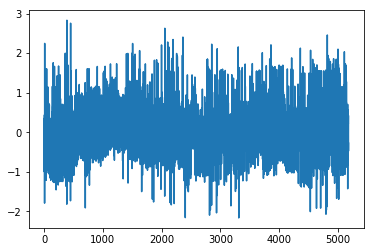

In [276]:
plt.plot(outliners)
plt.show()

In [277]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = TEST_SIZE, random_state = 0)

## Support Vector Machine - Linear

## http://scikit-learn.org/stable/modules/svm.html

## Training

In [278]:
classifer_train = svm.SVC(kernel='linear')

In [279]:
classifer_train.fit(xTrain, yTrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [280]:
xTrain.shape

(518, 18)

In [281]:
yTrain.shape

(518,)

In [282]:
classifer_train.support_vectors_

array([[  0.,  11.,   3., ...,   0.,  68., 168.],
       [  0.,   3.,   5., ...,   0.,  67., 170.],
       [  0.,  11.,   3., ...,   0.,  84., 182.],
       ...,
       [ 12.,   3.,   3., ...,   1.,  65., 172.],
       [ 13.,   4.,   4., ...,   0.,  98., 178.],
       [ 11.,  11.,   2., ...,   0.,  95., 196.]])

In [283]:
classifer_train.support_

array([ 33,  38,  42,  57,  58,  80,  97, 124, 140, 163, 173, 181, 184,
       185, 189, 256, 257, 286, 304, 344, 404, 446, 500, 509,  11,  25,
        47,  59,  70,  92,  99, 110, 115, 120, 121, 128, 133, 135, 136,
       139, 153, 156, 174, 177, 179, 188, 199, 204, 211, 222, 223, 225,
       238, 250, 263, 291, 294, 296, 306, 313, 315, 330, 350, 357, 358,
       360, 368, 372, 385, 390, 391, 398, 409, 413, 423, 428, 454, 458,
       473, 480, 483, 493, 502, 506, 514,   2,   4,  13,  17,  18,  19,
        27,  31,  32,  40,  41,  46,  53,  54,  78,  79,  81,  82, 102,
       105, 107, 108, 114, 117, 127, 132, 138, 144, 146, 147, 149, 155,
       157, 167, 169, 176, 178, 196, 197, 201, 207, 213, 226, 237, 242,
       245, 255, 259, 262, 272, 273, 280, 282, 283, 284, 287, 290, 293,
       302, 314, 321, 325, 326, 327, 328, 337, 338, 340, 351, 354, 359,
       363, 366, 374, 378, 379, 384, 388, 406, 407, 410, 411, 420, 421,
       424, 425, 435, 450, 455, 459, 463, 469, 471, 486, 487, 49

In [284]:
classifer_train.n_support_

array([ 24,  61,  99,  84,  48,   5,   1, 121,  13,  10,   2,   6,   1,
         2,   1,   2,   1,   2,   2])

In [285]:
clf_predictions = classifer_train.predict(xTest)
print("Accuracy: {}%".format(classifer_train.score(xTest, yTest) * 100 ))

Accuracy: 43.69369369369369%


## Testing

In [286]:
classifer_test = svm.SVC(kernel='linear')

In [287]:
classifer_test.fit(xTest, yTest)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [288]:
classifer_test.support_vectors_

array([[  0.,   9.,   3., ...,   0.,  98., 178.],
       [  0.,  10.,   3., ...,   0.,  75., 185.],
       [  0.,   7.,   3., ...,   0.,  98., 178.],
       ...,
       [  1.,  10.,   4., ...,   0.,  56., 171.],
       [ 13.,   6.,   4., ...,   0.,  98., 178.],
       [  6.,   7.,   3., ...,   1.,  65., 172.]])

In [289]:
classifer_test.support_

array([ 12,  25,  41,  67,  83,  93,  96,  98, 102, 124, 130, 153, 185,
       194,  37,  52,  53,  63,  66,  70,  80, 104, 110, 116, 127, 128,
       138, 157, 160, 165, 179, 182, 188, 189, 198, 200, 205, 209, 216,
         5,  10,  17,  21,  29,  31,  45,  48,  51,  54,  61,  76,  87,
        89, 131, 132, 133, 136, 139, 141, 150, 155, 156, 161, 167, 173,
       181, 183, 187, 202, 203, 206, 208, 212, 213, 214, 215,  13,  14,
        19,  20,  23,  26,  34,  43,  44,  56,  57,  62,  69,  88, 100,
       103, 105, 109, 114, 145, 147, 158, 164, 166, 171, 184, 193,   2,
         9,  15,  22,  35,  68,  78,  92, 120, 195, 211, 218, 168, 191,
         0,   3,   7,   8,  11,  18,  24,  27,  32,  33,  36,  38,  40,
        47,  55,  58,  59,  71,  72,  73,  74,  79,  81,  84,  86,  90,
        94,  95,  97, 111, 112, 115, 118, 119, 121, 122, 134, 135, 137,
       143, 146, 148, 152, 154, 169, 172, 174, 175, 177, 180, 186, 190,
       192, 196, 199, 210, 217, 219, 221,   6, 140, 149, 176, 20

In [290]:
classifer_test.n_support_

array([14, 25, 37, 27, 12,  2, 59,  6,  6,  4,  1,  2,  1,  1])

In [291]:
clf_predictions = classifer_test.predict(xTest)
print("Accuracy: {}%".format(classifer_test.score(xTest, yTest) * 100 ))

Accuracy: 75.67567567567568%


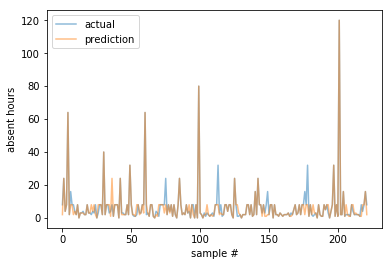

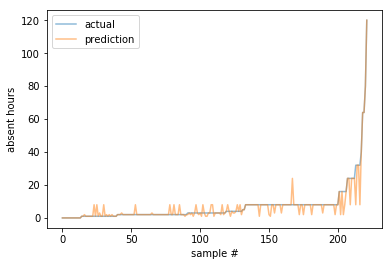

In [293]:
# Provided By Cormac Lavery
predictions = classifer_test.predict(xTest)
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest, alpha=.5, label="actual")
plt.plot(predictions, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = yTest.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

## Grid Search CV

## http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [294]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [295]:
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)

## Training

In [296]:
grid_search_train =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [297]:
grid_search_train_regr = grid_search_train.fit(xTrain,yTrain)

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    2.7s finished
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [298]:
print("Grid Search CV",'%error',procenterror(grid_search_train_regr.predict(xTrain),yTrain),'rmsle',rmsle(grid_search_train_regr.predict(xTrain),yTrain))

Grid Search CV %error 61.6 rmsle 0.794459921874045


In [300]:
print("Grid Search",'Classification Report')
classif=classification_report(yTrain,np.round(grid_search_train_regr.predict(xTrain)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(yTrain,np.round(grid_search_train_regr.predict(xTrain))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Grid Search Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        30
         1.0       0.54      0.34      0.42        62
         2.0       0.44      0.43      0.44       106
         3.0       0.40      0.48      0.43        84
         4.0       0.56      0.29      0.38        48
         5.0       0.00      0.00      0.00         5
         7.0       0.00      0.00      0.00         1
         8.0       0.52      0.82      0.64       140
        16.0       0.00      0.00      0.00        13
        24.0       0.00      0.00      0.00        10
        32.0       0.00      0.00      0.00         2
        40.0       0.00      0.00      0.00         6
        48.0       0.00      0.00      0.00         1
        56.0       0.00      0.00      0.00         2
        64.0       0.00      0.00      0.00         1
        80.0       0.00      0.00      0.00         2
       104.0       0.00      0.00      0.00    

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [302]:
grid_search_test =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [303]:
grid_search_test_regr = grid_search_train.fit(xTest,yTest)

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.5s finished
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [304]:
print("Grid Search CV",'%error',procenterror(grid_search_test_regr.predict(xTest),yTest),'rmsle',rmsle(grid_search_test_regr.predict(xTest),yTest))

Grid Search CV %error 52.0 rmsle 0.7140249181755999


In [305]:
print("Grid Search",'Classification Report')
classif=classification_report(yTest,np.round(grid_search_test_regr.predict(xTest)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(yTest,np.round(grid_search_test_regr.predict(xTest))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Grid Search Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
         1.0       0.82      0.35      0.49        26
         2.0       0.67      0.80      0.73        51
         3.0       0.39      0.57      0.46        28
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         2
         8.0       0.62      0.85      0.72        68
        16.0       1.00      0.17      0.29         6
        24.0       1.00      0.17      0.29         6
        32.0       0.00      0.00      0.00         4
        40.0       0.00      0.00      0.00         1
        64.0       0.00      0.00      0.00         2
        80.0       0.00      0.00      0.00         1
       120.0       0.00      0.00      0.00         1

   micro avg       0.62      0.62      0.62       222
   macro avg       0.38      0.27      0.27       222
weighted avg       0.60      0.62      0.57   

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Linear Regression

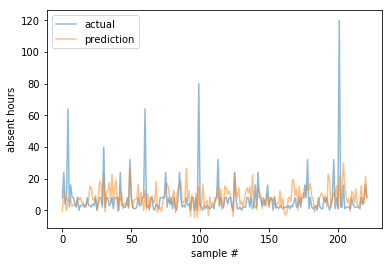

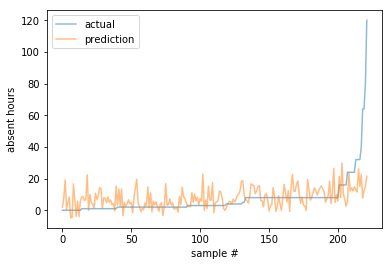

regression model stats
140.67620545301506
0.07967867212723467
classification model stats based on linear accuracy
13.45945945945946
0.911946533087882


In [306]:
# Provided By Cormac Lavery
regression = LinearRegression()
regression.fit(xTrain, yTrain)
predictions_regression = regression.predict(xTest)

plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest, alpha=.5, label="actual")
plt.plot(predictions_regression, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = yTest.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions_regression[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

print("regression model stats")
print(mean_squared_error(yTest, predictions_regression))
print(r2_score(yTest, predictions_regression))

print("classification model stats based on linear accuracy")
print(mean_squared_error(yTest, predictions))
print(r2_score(yTest, predictions))

In [ ]:
# References
# https://www.learnopencv.com/svm-using-scikit-learn-in-python/
# https://www.kaggle.com/plarmuseau/ten-100-correct-models#
# http://www.datasciencemadesimple.com/box-plot-in-python/
# https://www.youtube.com/watch?v=0pP4EwWJgIU
# https://fizzylogic.nl/2017/11/07/learn-how-to-build-flexible-machine-learning-pipelines-in-sklearn/
# https://www.youtube.com/watch?v=URdnFlZnlaE
# http://tullo.ch/articles/svm-py/ 